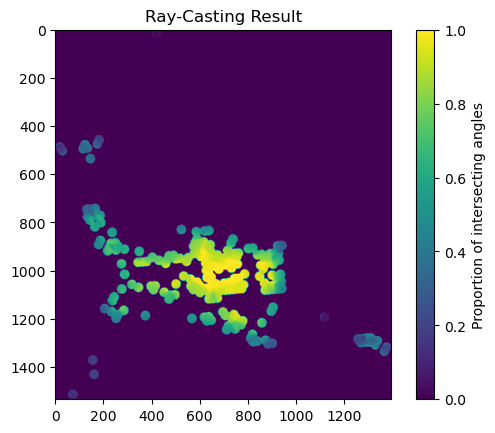

In [ ]:
import rasterio
import numpy as np
from matplotlib import pyplot as plt

# Ray-casting function
def vectorized_ray_cast_proportions(raster, min_radius, max_radius, num_angles=360):
    rows, cols = raster.shape
    result = np.zeros_like(raster, dtype=float)
    angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)
    directions = np.stack([np.cos(angles), np.sin(angles)], axis=-1)
    radii = np.arange(min_radius, max_radius + 1)
    offsets = np.round(directions[:, None, :] * radii[:, None]).astype(int)
    y_indices, x_indices = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
    active_cells = np.argwhere(raster == 1)
    for y, x in active_cells:
        ray_paths = offsets + np.array([y, x])
        ray_paths[..., 0] = np.clip(ray_paths[..., 0], 0, rows - 1)
        ray_paths[..., 1] = np.clip(ray_paths[..., 1], 0, cols - 1)
        hits = np.any(raster[ray_paths[..., 0], ray_paths[..., 1]] == 1, axis=1)
        result[y, x] = np.sum(hits) / num_angles
    return result

# Read the .tif file
input_tif = "E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/intersection_test/still_active_redo_resamp100.tif"
with rasterio.open(input_tif) as src:
    raster = src.read(1)  # Read the first band as a 2D numpy array
    raster_meta = src.meta  # Save metadata for writing output

# Ensure raster is binary (1 for active, 0 for inactive)
raster_binary = (raster > 0).astype(np.uint8)

# Define parameters for ray casting
min_radius = 50
max_radius = 190
num_angles = 360

# Process the raster
result = vectorized_ray_cast_proportions(raster_binary, min_radius, max_radius, num_angles)

# Save the result to a new .tif file
output_tif = "E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/intersection_test/still_active_angle.tif"
raster_meta.update(dtype="float32", count=1)  # Update metadata for output

with rasterio.open(output_tif, "w", **raster_meta) as dst:
    dst.write(result, 1)

# Visualize the output
plt.imshow(result, cmap="viridis")
plt.colorbar(label="Proportion of intersecting angles")
plt.title("Ray-Casting Result")
plt.show()

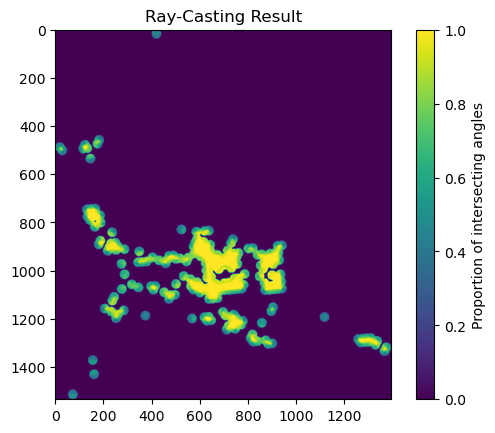

In [2]:
import rasterio
import numpy as np
from matplotlib import pyplot as plt

# Ray-casting function
def vectorized_ray_cast_proportions(raster, min_radius, max_radius, num_angles=360):
    rows, cols = raster.shape
    result = np.zeros_like(raster, dtype=float)
    angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)
    directions = np.stack([np.cos(angles), np.sin(angles)], axis=-1)
    radii = np.arange(min_radius, max_radius + 1)
    offsets = np.round(directions[:, None, :] * radii[:, None]).astype(int)
    y_indices, x_indices = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
    active_cells = np.argwhere(raster == 1)
    for y, x in active_cells:
        ray_paths = offsets + np.array([y, x])
        ray_paths[..., 0] = np.clip(ray_paths[..., 0], 0, rows - 1)
        ray_paths[..., 1] = np.clip(ray_paths[..., 1], 0, cols - 1)
        hits = np.any(raster[ray_paths[..., 0], ray_paths[..., 1]] == 1, axis=1)
        result[y, x] = np.sum(hits) / num_angles
    return result

# Read the .tif file
input_tif = "E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/intersection_test/still_active_redo_resamp100.tif"
with rasterio.open(input_tif) as src:
    raster = src.read(1)  # Read the first band as a 2D numpy array
    raster_meta = src.meta  # Save metadata for writing output

# Ensure raster is binary (1 for active, 0 for inactive)
raster_binary = (raster > 0).astype(np.uint8)

# Define parameters for ray casting
min_radius = 20
max_radius = 48
num_angles = 360

# Process the raster
result = vectorized_ray_cast_proportions(raster_binary, min_radius, max_radius, num_angles)

# Save the result to a new .tif file
output_tif = "E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/intersection_test/still_active_angle_48.tif"
raster_meta.update(dtype="float32", count=1)  # Update metadata for output

with rasterio.open(output_tif, "w", **raster_meta) as dst:
    dst.write(result, 1)

# Visualize the output
plt.imshow(result, cmap="viridis")
plt.colorbar(label="Proportion of intersecting angles")
plt.title("Ray-Casting Result")
plt.show()

This works. Adds progress bar.

Processing active cells: 100%|██████████| 168807/168807 [01:58<00:00, 1422.49it/s]


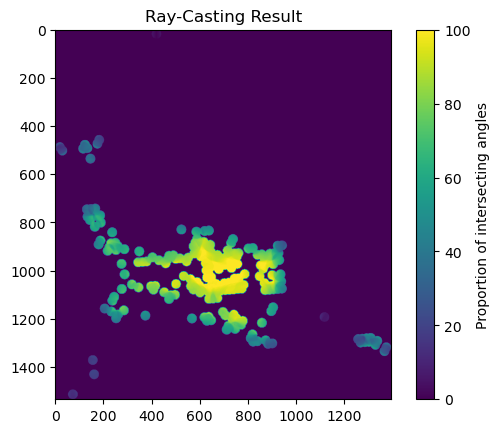

In [5]:
import rasterio
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

def ray_cast_with_progress(raster, min_radius, max_radius, num_angles=360):
    """
    Compute the proportion of angles that intersect active areas for each cell in a raster.
    Includes a progress bar using tqdm.

    Parameters:
        raster (numpy.ndarray): 2D array where active areas are `1` and inactive are `0`.
        min_radius (int): Minimum radius for ray casting (in cells).
        max_radius (int): Maximum radius for ray casting (in cells).
        num_angles (int): Number of angles (rays) to cast per cell.

    Returns:
        numpy.ndarray: A 2D array with the proportion of intersecting angles for each cell.
    """
    rows, cols = raster.shape
    result = np.zeros_like(raster, dtype=float)

    # Define angles and ray directions
    angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)
    directions = np.stack([np.cos(angles), np.sin(angles)], axis=-1)  # Shape: (num_angles, 2)
    radii = np.arange(min_radius, max_radius + 1)
    offsets = np.round(directions[:, None, :] * radii[:, None]).astype(int)  # Shape: (num_angles, num_radii, 2)

    # Find active cells
    active_cells = np.argwhere(raster == 1)

    # Loop through active cells with a progress bar
    for y, x in tqdm(active_cells, desc="Processing active cells"):
        ray_paths = offsets + np.array([y, x])  # Shape: (num_angles, num_radii, 2)
        ray_paths[..., 0] = np.clip(ray_paths[..., 0], 0, rows - 1)
        ray_paths[..., 1] = np.clip(ray_paths[..., 1], 0, cols - 1)

        # Evaluate ray intersections with active areas
        hits = np.any(raster[ray_paths[..., 0], ray_paths[..., 1]] == 1, axis=1)  # Shape: (num_angles,)
        result[y, x] = np.round(((np.sum(hits) / num_angles) * 100), 0)

    return result

# Read the .tif file
input_tif = "E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/intersection_test/still_active_redo_resamp100.tif"
with rasterio.open(input_tif) as src:
    raster = src.read(1)  # Read the first band as a 2D numpy array
    raster_meta = src.meta  # Save metadata for writing output

# Ensure raster is binary (1 for active, 0 for inactive)
raster_binary = (raster > 0).astype(np.uint8)

# Define parameters for ray casting
min_radius = 48
max_radius = 190
num_angles = 360

# Process the raster
result = ray_cast_with_progress(raster_binary, min_radius, max_radius, num_angles)

# Save the result to a new .tif file
output_tif = "E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/intersection_test/still_active_angle_avg_dsp.tif"
raster_meta.update(dtype="int16", count=1)  # Update metadata for output. Was originally "float32"

with rasterio.open(output_tif, "w", **raster_meta) as dst:
    dst.write(result, 1)

# Visualize the output
plt.imshow(result, cmap="viridis")
plt.colorbar(label="Proportion of intersecting angles")
plt.title("Ray-Casting Result")
plt.show()

Processing active cells: 100%|██████████| 168807/168807 [00:29<00:00, 5723.00it/s]


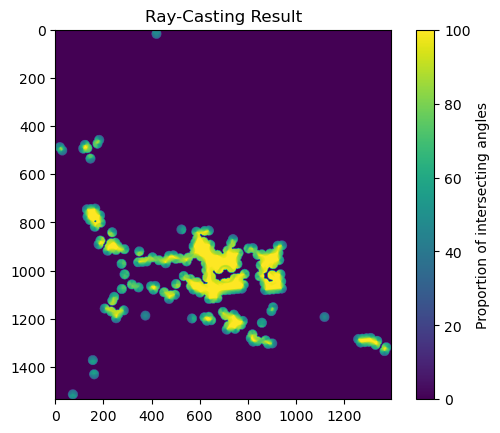

In [ ]:
import rasterio
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

def ray_cast_with_progress(raster, min_radius, max_radius, num_angles=360):
    """
    Compute the proportion of angles that intersect active areas for each cell in a raster.
    Includes a progress bar using tqdm.

    Parameters:
        raster (numpy.ndarray): 2D array where active areas are `1` and inactive are `0`.
        min_radius (int): Minimum radius for ray casting (in cells).
        max_radius (int): Maximum radius for ray casting (in cells).
        num_angles (int): Number of angles (rays) to cast per cell.

    Returns:
        numpy.ndarray: A 2D array with the proportion of intersecting angles for each cell.
    """
    rows, cols = raster.shape
    result = np.zeros_like(raster, dtype=float)

    # Define angles and ray directions
    angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)
    directions = np.stack([np.cos(angles), np.sin(angles)], axis=-1)  # Shape: (num_angles, 2)
    radii = np.arange(min_radius, max_radius + 1)
    offsets = np.round(directions[:, None, :] * radii[:, None]).astype(int)  # Shape: (num_angles, num_radii, 2)

    # Find active cells
    active_cells = np.argwhere(raster == 1)

    # Loop through active cells with a progress bar
    for y, x in tqdm(active_cells, desc="Processing active cells"):
        ray_paths = offsets + np.array([y, x])  # Shape: (num_angles, num_radii, 2)
        ray_paths[..., 0] = np.clip(ray_paths[..., 0], 0, rows - 1)
        ray_paths[..., 1] = np.clip(ray_paths[..., 1], 0, cols - 1)

        # Evaluate ray intersections with active areas
        hits = np.any(raster[ray_paths[..., 0], ray_paths[..., 1]] == 1, axis=1)  # Shape: (num_angles,)
        result[y, x] = np.round(((np.sum(hits) / num_angles) * 100), 0)

    return result

# Read the .tif file
input_tif = "E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/intersection_test/still_active_redo_resamp100.tif"
with rasterio.open(input_tif) as src:
    raster = src.read(1)  # Read the first band as a 2D numpy array
    raster_meta = src.meta  # Save metadata for writing output

# Ensure raster is binary (1 for active, 0 for inactive)
raster_binary = (raster > 0).astype(np.uint8)

# Define parameters for ray casting
min_radius = 20
max_radius = 48
num_angles = 360

# Process the raster
result = ray_cast_with_progress(raster_binary, min_radius, max_radius, num_angles)

# Save the result to a new .tif file
output_tif = "E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/intersection_test/still_active_angle_48.tif"
raster_meta.update(dtype="int16", count=1)  # Update metadata for output. Was originally "float32"

with rasterio.open(output_tif, "w", **raster_meta) as dst:
    dst.write(result, 1)

# Visualize the output
plt.imshow(result, cmap="viridis")
plt.colorbar(label="Proportion of intersecting angles")
plt.title("Ray-Casting Result")
plt.show()

Processing active cells:   0%|          | 0/168807 [00:00<?, ?it/s]

Processing active cells: 100%|██████████| 168807/168807 [01:02<00:00, 2687.09it/s]


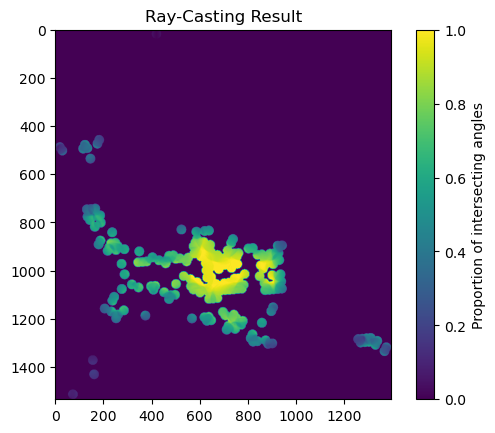

In [ ]:
import rasterio
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

def ray_cast_with_progress(raster, min_radius, max_radius, num_angles=360):
    """
    Compute the proportion of angles that intersect active areas for each cell in a raster.
    Includes a progress bar using tqdm.

    Parameters:
        raster (numpy.ndarray): 2D array where active areas are `1` and inactive are `0`.
        min_radius (int): Minimum radius for ray casting (in cells).
        max_radius (int): Maximum radius for ray casting (in cells).
        num_angles (int): Number of angles (rays) to cast per cell.

    Returns:
        numpy.ndarray: A 2D array with the proportion of intersecting angles for each cell.
    """
    rows, cols = raster.shape
    result = np.zeros_like(raster, dtype=float)

    # Define angles and ray directions
    angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)
    directions = np.stack([np.cos(angles), np.sin(angles)], axis=-1)  # Shape: (num_angles, 2)
    radii = np.arange(min_radius, max_radius + 1)
    offsets = np.round(directions[:, None, :] * radii[:, None]).astype(int)  # Shape: (num_angles, num_radii, 2)

    # Find active cells
    active_cells = np.argwhere(raster == 1)

    # Loop through active cells with a progress bar
    for y, x in tqdm(active_cells, desc="Processing active cells"):
        ray_paths = offsets + np.array([y, x])  # Shape: (num_angles, num_radii, 2)
        ray_paths[..., 0] = np.clip(ray_paths[..., 0], 0, rows - 1)
        ray_paths[..., 1] = np.clip(ray_paths[..., 1], 0, cols - 1)

        # Evaluate ray intersections with active areas
        hits = np.any(raster[ray_paths[..., 0], ray_paths[..., 1]] == 1, axis=1)  # Shape: (num_angles,)
        result[y, x] = np.round(((np.sum(hits) / num_angles) * 100), 0)

    return result

# Read the .tif file
input_tif = "E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/intersection_test/still_active_redo_resamp100.tif"
with rasterio.open(input_tif) as src:
    raster = src.read(1)  # Read the first band as a 2D numpy array
    raster_meta = src.meta  # Save metadata for writing output

# Ensure raster is binary (1 for active, 0 for inactive)
raster_binary = (raster > 0).astype(np.uint8)

# Define parameters for ray casting
min_radius = 48
max_radius = 120
num_angles = 360

# Process the raster
result = ray_cast_with_progress(raster_binary, min_radius, max_radius, num_angles)

# Save the result to a new .tif file
output_tif = "E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/intersection_test/still_active_angle_120.tif"
raster_meta.update(dtype="int16", count=1)  # Update metadata for output. Was originally "float32"

with rasterio.open(output_tif, "w", **raster_meta) as dst:
    dst.write(result, 1)

# Visualize the output
plt.imshow(result, cmap="viridis")
plt.colorbar(label="Proportion of intersecting angles")
plt.title("Ray-Casting Result")
plt.show()

Does not work.

In [ ]:
import rasterio
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
from functools import partial

def process_cell(args, raster, directions, radii, rows, cols):
    """Process a single cell for ray casting."""
    y, x = args
    offsets = np.round(directions[:, None, :] * radii[:, None]).astype(int)
    ray_paths = offsets + np.array([y, x])
    ray_paths[..., 0] = np.clip(ray_paths[..., 0], 0, rows - 1)
    ray_paths[..., 1] = np.clip(ray_paths[..., 1], 0, cols - 1)
    hits = np.any(raster[ray_paths[..., 0], ray_paths[..., 1]] == 1, axis=1)
    return (y, x, np.sum(hits) / len(directions))

def vectorized_ray_cast_proportions(raster, min_radius, max_radius, num_angles=360, num_processes=None):
    """Vectorized ray casting with parallel processing and progress bar."""
    # Initialize parameters
    rows, cols = raster.shape
    result = np.zeros_like(raster, dtype=float)
    angles = np.linspace(0, 2 * np.pi, num_angles, endpoint=False)
    directions = np.stack([np.cos(angles), np.sin(angles)], axis=-1)
    radii = np.arange(min_radius, max_radius + 1)
    
    # Get active cells
    active_cells = np.argwhere(raster == 1)
    
    # Set up multiprocessing
    if num_processes is None:
        num_processes = mp.cpu_count() - 1  # Leave one CPU free
    
    # Create partial function with fixed arguments
    process_func = partial(
        process_cell,
        raster=raster,
        directions=directions,
        radii=radii,
        rows=rows,
        cols=cols
    )
    
    # Process cells in parallel with progress bar
    with mp.Pool(num_processes) as pool:
        results = list(tqdm(
            pool.imap(process_func, active_cells),
            total=len(active_cells),
            desc="Processing cells"
        ))
    
    # Populate result array
    for y, x, value in results:
        result[y, x] = value
        
    return result

def process_raster(input_path, output_path, min_radius, max_radius, num_angles=360):
    """Main function to process the raster file."""
    print("Reading input raster...")
    with rasterio.open(input_path) as src:
        raster = src.read(1)
        raster_meta = src.meta
    
    # Convert to binary
    print("Converting to binary raster...")
    raster_binary = (raster > 0).astype(np.uint8)
    
    # Process the raster
    print("Processing raster...")
    result = vectorized_ray_cast_proportions(
        raster_binary,
        min_radius,
        max_radius,
        num_angles
    )
    
    # Save results
    print("Saving results...")
    raster_meta.update(dtype="float32", count=1)
    with rasterio.open(output_path, "w", **raster_meta) as dst:
        dst.write(result, 1)
    
    return result

if __name__ == "__main__":
    # Parameters
    input_tif = "E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/intersection_test/still_active_redo_resamp100.tif"
    output_tif = "E:/!!Research/!!!Data/graph_analysis/igraph_metrics_data/all_leks_metrics/redone/intersection_test/still_active_angle.tif"
    min_radius = 50
    max_radius = 190
    num_angles = 360
    
    # Process the raster
    result = process_raster(input_tif, output_tif, min_radius, max_radius, num_angles)
    
    # Visualize results
    plt.figure(figsize=(10, 8))
    plt.imshow(result, cmap="viridis")
    plt.colorbar(label="Proportion of intersecting angles")
    plt.title("Ray-Casting Result")
    plt.show()

Reading input raster...
Converting to binary raster...
Processing raster...


Processing cells:   0%|          | 0/168807 [00:00<?, ?it/s]